---
title: CAGE Brain plots for three well-predicted genes
description: Earlier we plotted predicts vs observed expression, but they did not show any association. Here, we investigate the CAGE predictions further
author: Sabrina Mi
date: 8/4/23
---

In [1]:
import tensorflow as tf
# Make sure the GPU is enabled
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'

2023-08-11 15:54:08.579990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 15:54:14.184182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/soft/libraries/trt/TensorRT-8.5.2.2.Linux.x86_64-gnu.cuda-11.8.cudnn8.6/lib:/soft/libraries/nccl/nccl_2.16.2-1+cuda11.8_x86_64/lib:/soft/libraries/cudnn/cudnn-11-linux-x64-v8.6.0.163/lib:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/pe/papi/6.0.0.14/lib64:/opt/cray/libfabric/1.11.0.4.125/lib64:/

In [2]:
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/home/s1mi/enformer_rat_data/reference_genome/rn7_genome.fasta'



In [9]:
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')


In [10]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

In [11]:
# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)

  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

In [12]:
# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

In [13]:
model = Enformer(model_path)

fasta_extractor = FastaStringExtractor(fasta_file)

In [14]:
gene_list = ['ENSRNOG00000001342', 'ENSRNOG00000020624', 'ENSRNOG00000058006']
annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt", sep="\t", index_col='geneId')
gene_annot = annot_df.loc[gene_list].iloc[:, :6]

/tmp/ipykernel_102315/2838342331.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/rn7.gene.txt", sep="\t", index_col='geneId')


In [15]:
import os
import h5py
import random

In [17]:
gene = 'ENSRNOG00000001342'
chromosome = 12
start = 33261476
end = 33293932
predictions_dir = "/home/s1mi/enformer_rat_pipeline/predictions_folder/personalized_enformer_minimal_some_regions/predictions_2023-07-26/enformer_predictions"


In [18]:
predictions = {}

for gene in gene_annot.index:
    chromosome = gene_annot.loc[gene]['chromosome']
    start = gene_annot.loc[gene]['start']
    end = gene_annot.loc[gene]['end']
    gene_predictions = {}
    for individual in os.listdir(predictions_dir):
        interval = f'chr{chromosome}_{start}_{end}'
        predictions_file = h5py.File(f"{predictions_dir}/{individual}/haplotype1/{interval}_predictions.h5", "r")
        gene_predictions[individual] = predictions_file[interval][()]
    predictions[gene] = gene_predictions

In [19]:
print(gene_annot)

                            geneSymbol chromosome      start        end  \
geneId                                                                    
ENSRNOG00000001342  ENSRNOG00000001342         12   33261476   33293932   
ENSRNOG00000020624              Acadsb          1  186188987  186230379   
ENSRNOG00000058006                Sncg         16    9700514    9705368   

                   strand        tss  
geneId                                
ENSRNOG00000001342      -   33293932  
ENSRNOG00000020624      +  186188987  
ENSRNOG00000058006      -    9705368  


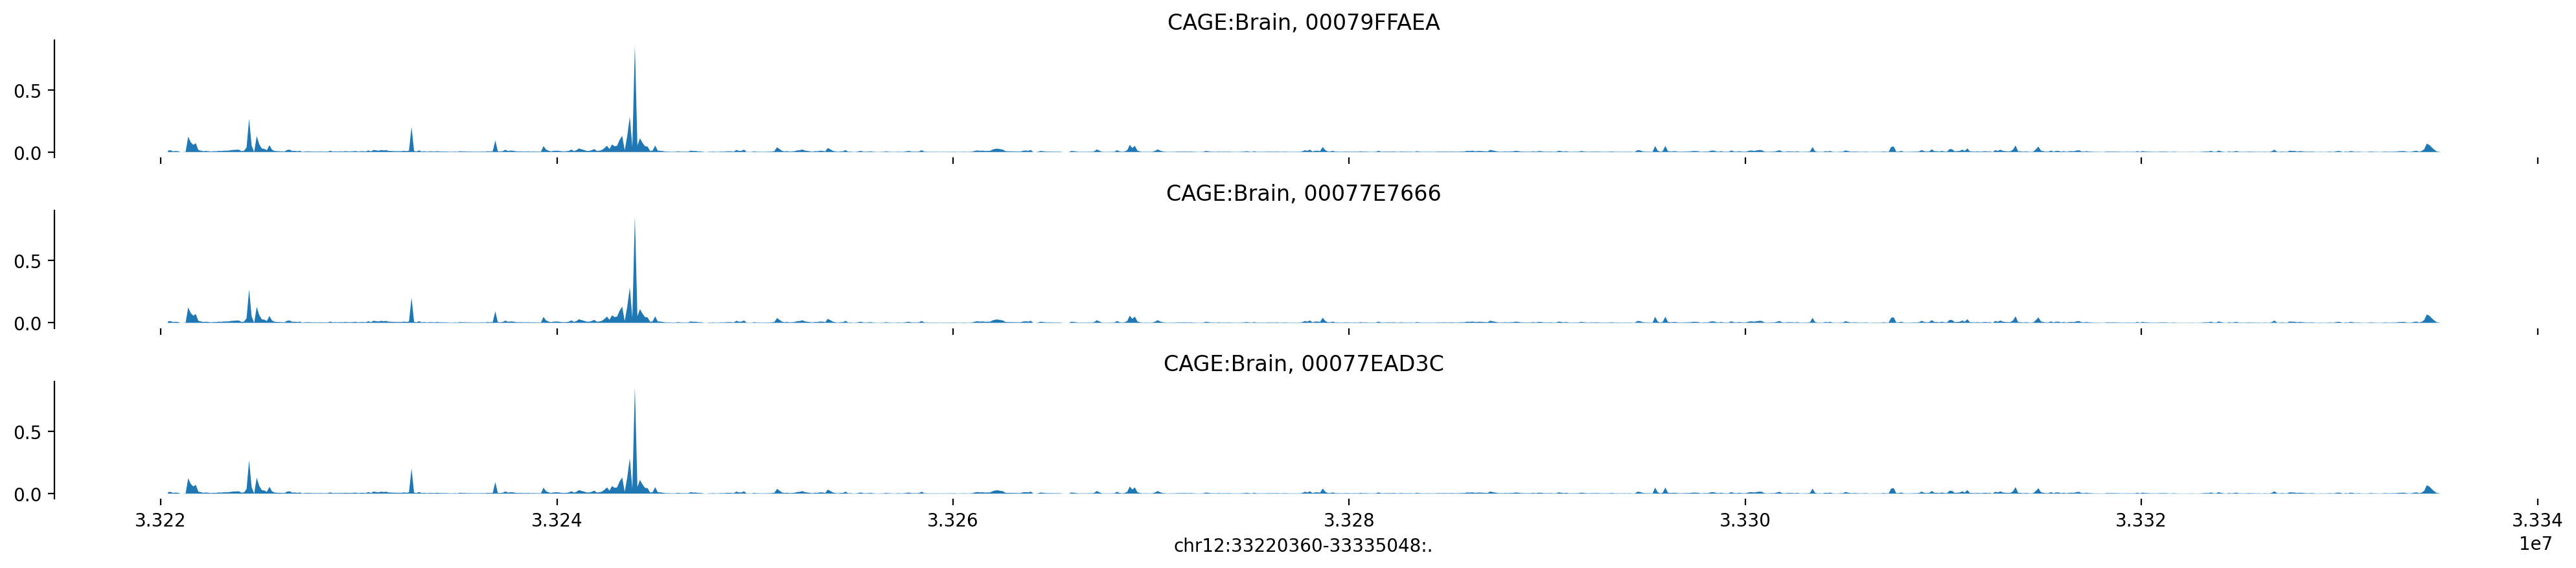

In [20]:
# @title Plot tracks

# 'ENSRNOG00000001342'
target_interval = kipoiseq.Interval('chr12', 33261476, 33293932).resize(114688)
tracks = {}
individuals = list(predictions['ENSRNOG00000001342'].keys())
sample = random.sample(individuals, 3)
for individual in sample:
    tracks['CAGE:Brain, ' + individual] = np.log10(1 + predictions['ENSRNOG00000001342'][individual][:, 4980])
plot_tracks(tracks, target_interval)

We sampled 3 rats to plot CAGE expression around ENSRNOG00000001342. The TSS is at 33293932, where we see a small peak at the edge of the plot. But the biggest peak lies somewhere in the middle of the gene, which we'll have to investigate futher. We'll also check the other two genes.

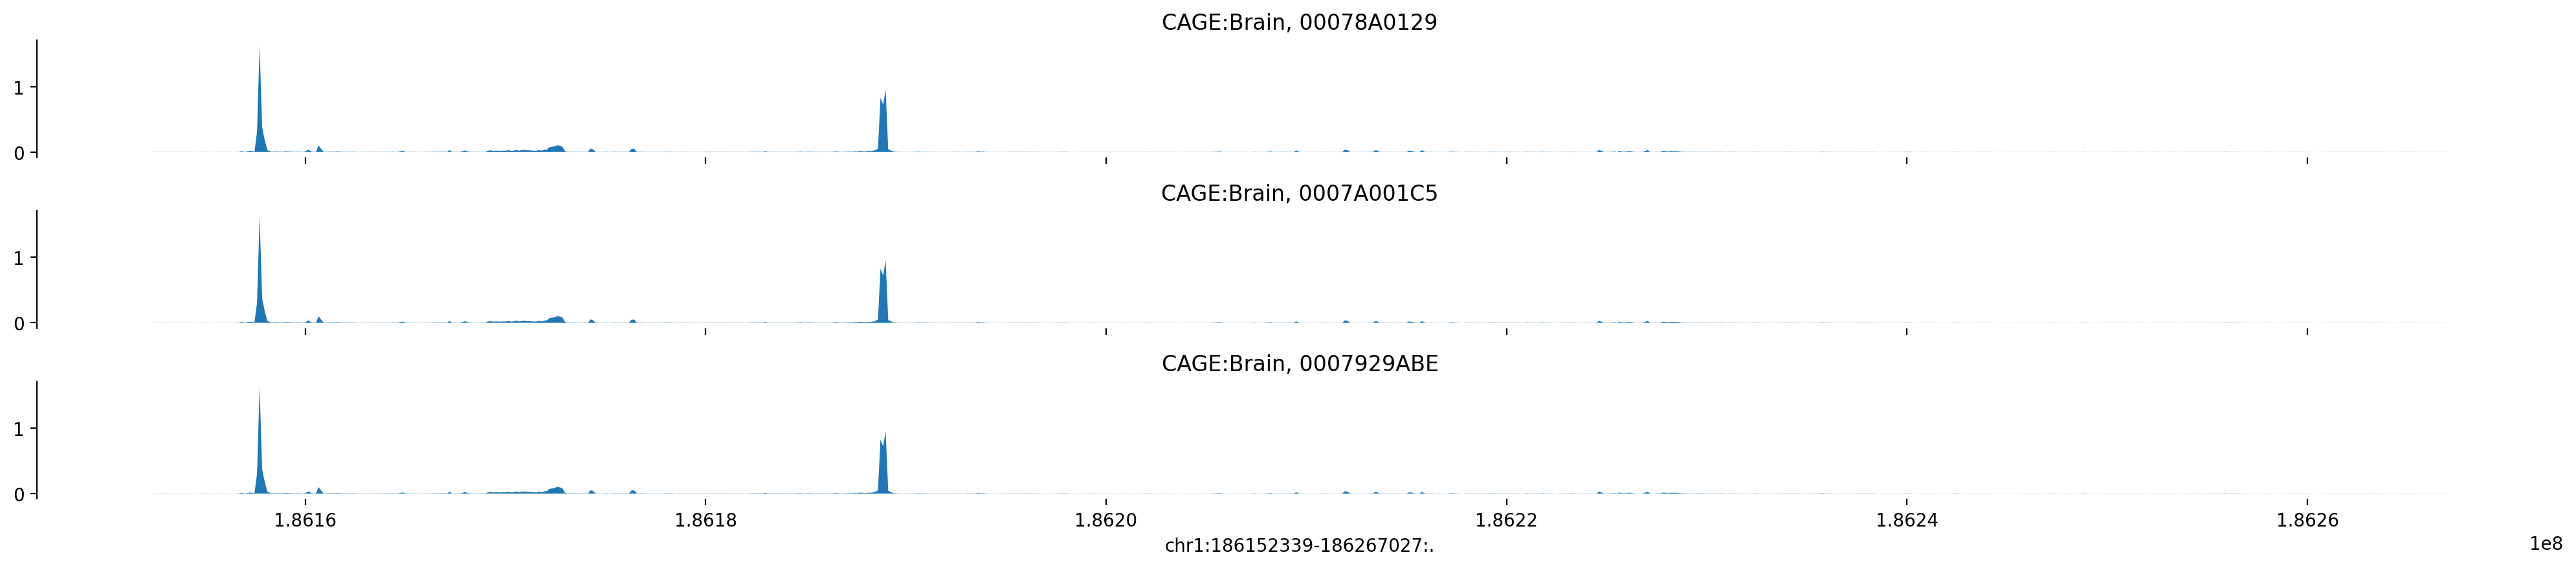

In [28]:
# ENSRNOG00000020624
target_interval = kipoiseq.Interval('chr1', 186188987, 186230379).resize(114688)
tracks = {}
sample = random.sample(individuals, 3)
for individual in sample:
    tracks['CAGE:Brain, ' + individual] = np.log10(1 + predictions['ENSRNOG00000020624'][individual][:, 4980])
plot_tracks(tracks, target_interval)


The peak at the start lines up with the TSS for ENSRNOG00000020624 (pos: 186230379). The second, smaller peak could be another TSS.

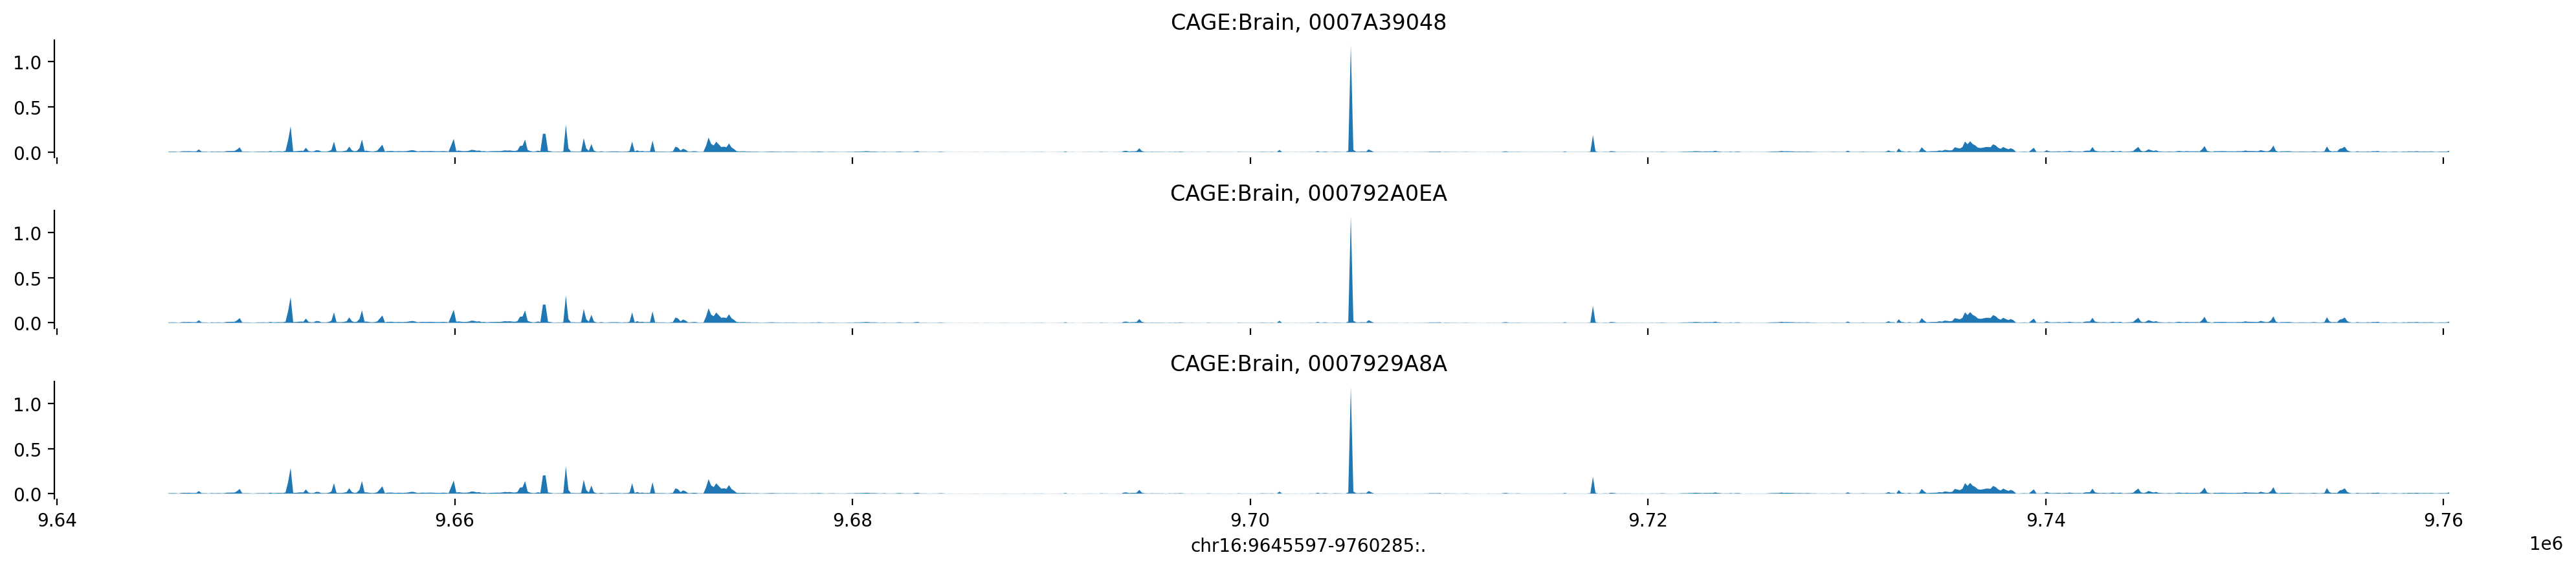

In [32]:
# ENSRNOG00000058006
target_interval = kipoiseq.Interval('chr16', 9700514, 9705368).resize(114688)
tracks = {}
sample = random.sample(individuals, 3)
for individual in sample:
    tracks['CAGE:Brain, ' + individual] = np.log10(1 + predictions['ENSRNOG00000058006'][individual][:, 4980])
plot_tracks(tracks, target_interval)

The TSS for ENSRNOG00000058006 is at the end (9705368), which is roughly the peak in the plot. In summary, two out of three genes have CAGE peaks where we expected at the TSS. 


This probably means Enformer is correctly identifying TSS, and the low CAGE values around the TSS for the first gene indicate that ENSRNOG00000001342 is not expressed in brain tissue.